# Modeling

In [22]:
import os
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

## Dataset preparation

In [23]:
photo_path = os.path.realpath('/kaggle/input/inaturalist-photos/photos')

In [24]:
animal_classes = ['alces_alces', 'sciurus_carolinensis', 'ursus_americanus',
       'homo_sapiens', 'odocoileus_virginianus', 'peromyscus_maniculatus',
       'erethizon_dorsatum', 'vulpes_vulpes', 'blarina_brevicauda',
       'canis_lycaon', 'castor_canadensis', 'neogale_vison',
       'canis_latrans', 'lontra_canadensis', 'tamias_striatus',
       'canis_familiaris', 'ondatra_zibethicus', 'mephitis_mephitis',
       'tamiasciurus_hudsonicus', 'lynx_rufus', 'procyon_lotor',
       'felis_catus', 'marmota_monax', 'sylvilagus_floridanus',
       'lepus_americanus', 'didelphis_virginiana', 'pekania_pennanti',
       'peromyscus', 'canidae', 'urocyon_cinereoargenteus',
       'rattus_norvegicus', 'microtus_pennsylvanicus', 'martes_americana',
       'carnivora', 'parascalops_breweri', 'eptesicus_fuscus',
       'mustela_richardsonii', 'condylura_cristata', 'rodentia',
       'sciuridae', 'leporidae', 'placentalia', 'vespertilionidae']

In [25]:
image_size = 300

In [26]:
ds_train, ds_valid = image_dataset_from_directory(  
    directory= photo_path,
    labels="inferred",
    label_mode="int",
    class_names=animal_classes,
    color_mode="rgb",
    batch_size=32,
    image_size=(image_size, image_size),
    shuffle=True,
    seed=42,
    validation_split=0.1,
    subset='both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    #data_format='.jpg',
)

Found 47580 files belonging to 43 classes.
Using 42822 files for training.
Using 4758 files for validation.


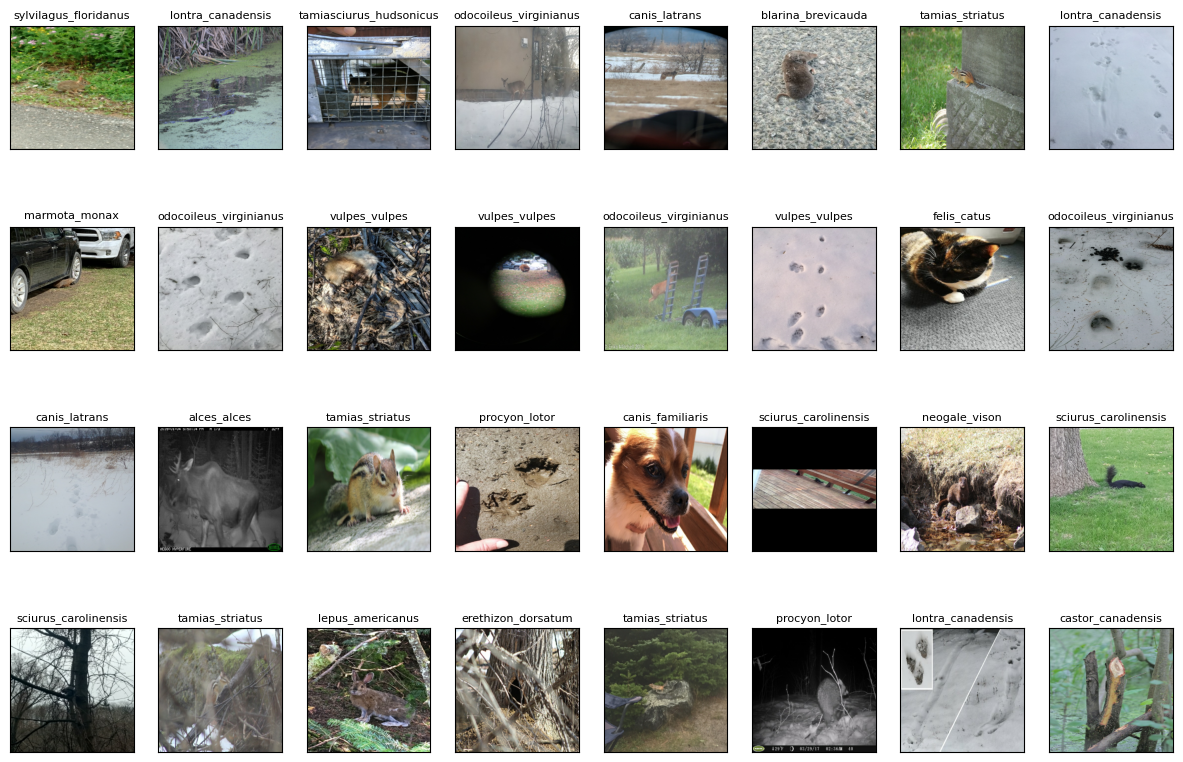

In [27]:
plt.figure(figsize=(15, 10))
for image, label in ds_train.take(1):
    for i in range (32):
        ax = plt.subplot(4, 8, i + 1)
        ax.imshow(image[i,:].numpy().astype("uint8"))
        ax.set_title(ds_train.class_names[label[i]], size=8)
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

## Data Augmentation

In [28]:
augmentation = keras.Sequential([
    layers.RandomBrightness(0.2, [0.0, 255.0]),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(0.1),
])

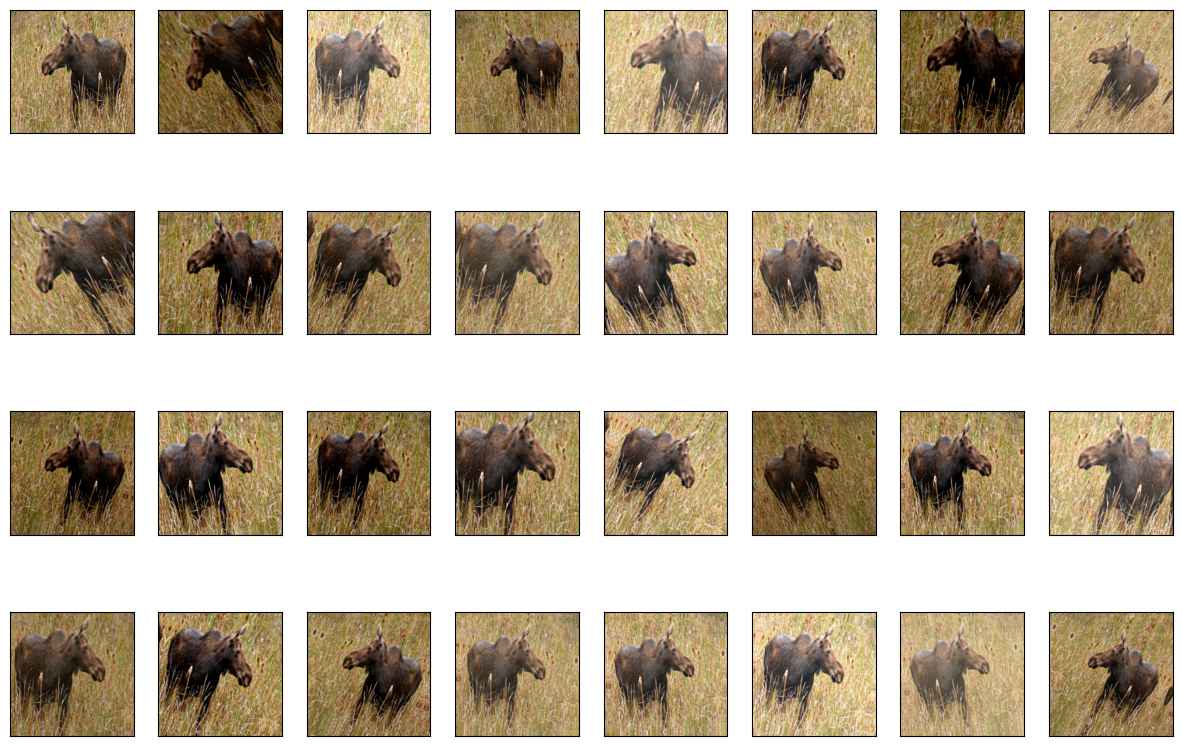

In [29]:
plt.figure(figsize=(15, 10))
for image, label in ds_train.take(1):
    ax = plt.subplot(4, 8, 1)
    ax.imshow(image[1,:].numpy().astype("uint8"))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    for i in range (31):
        ax = plt.subplot(4, 8, i + 2)
        ax.imshow(augmentation(image[1,:]).numpy().astype("uint8"))
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

## CNet Model

In [30]:
model_1 = keras.Sequential([
    layers.Input((150, 150, 3)),
    augmentation,
    layers.Rescaling(1/255),

    layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPool2D(2),
    
    layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPool2D(2),
    
    layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    layers.MaxPool2D(2),
    
    layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    layers.MaxPool2D(2),
    
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(43, activation='softmax')

])


In [31]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=1E-4)
model_1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (300, 300, 3)             0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                 

In [32]:
#history_1 = model_1.fit(ds_train, validation_data=ds_valid, epochs=50, callbacks=[early_stopping])

In [33]:
 def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize = (15,5))
    axs[0].plot(history.history['loss'], label = 'training')
    axs[0].plot(history.history['val_loss'], label = 'validation')
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])

    axs[0].legend()
    axs[0].set_title('Loss')
    axs[0].set_xlim(0)
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('Loss')

    axs[1].set_xlim(0)
    axs[1].set_title('Accuracy')
    axs[1].set_ylim(0,1)
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('Loss');

In [34]:
#plot_history(history_1)

In [35]:
#model_1.save_weights('/kaggle/working/models/CNet_1.weights.h5')

In [36]:
#model_1.load_weights('/kaggle/working/models/CNet_1.weights.h5')

After trying different model architectures, 30% accuracy is about the highest we can get. We will try using a pretrained network to improve accuracy.

# Pretrained Model

We'll reuse `EfficientNetB0` pretrained on `imagenet` and build a custom top layers for our classification task. 

In [37]:
keras.backend.clear_session()

### Training the top layers

In [38]:
EfficientNetV2B0 = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(image_size, image_size, 3),
    pooling=None,
)

In [39]:
EfficientNetV2B0.trainable = False

In [40]:
inputs = keras.Input((image_size, image_size, 3))
x = augmentation(inputs)
x = EfficientNetV2B0(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)
outputs = layers.Dense(43, activation='softmax')(x)

pretrained = keras.Model(inputs, outputs)

pretrained.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 10, 10, 1280)      5919312   N          
 nal)                                                                       
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0         Y          
                                                                            
 dense (Dense)               (None, 512)               655872

In [41]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=1E-3)
pretrained.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
history_pretrained = pretrained.fit(ds_train, validation_data=ds_valid, epochs=20, callbacks=[early_stopping])

Epoch 1/20
1339/1339 [==============================] - 115s 77ms/step - loss: 1.8483 - accuracy: 0.5145 - val_loss: 1.3558 - val_accuracy: 0.6194
Epoch 2/20
1339/1339 [==============================] - 95s 71ms/step - loss: 1.4680 - accuracy: 0.5976 - val_loss: 1.2562 - val_accuracy: 0.6448
Epoch 3/20
1339/1339 [==============================] - 94s 70ms/step - loss: 1.3664 - accuracy: 0.6219 - val_loss: 1.2196 - val_accuracy: 0.6549
Epoch 4/20
1339/1339 [==============================] - 95s 71ms/step - loss: 1.3001 - accuracy: 0.6383 - val_loss: 1.1845 - val_accuracy: 0.6662
Epoch 5/20
1339/1339 [==============================] - 95s 71ms/step - loss: 1.2500 - accuracy: 0.6508 - val_loss: 1.1605 - val_accuracy: 0.6732
Epoch 6/20
1339/1339 [==============================] - 97s 72ms/step - loss: 1.1952 - accuracy: 0.6668 - val_loss: 1.1366 - val_accuracy: 0.6782
Epoch 7/20
1339/1339 [==============================] - 97s 72ms/step - loss: 1.1529 - accuracy: 0.6748 - val_loss: 1.1218 

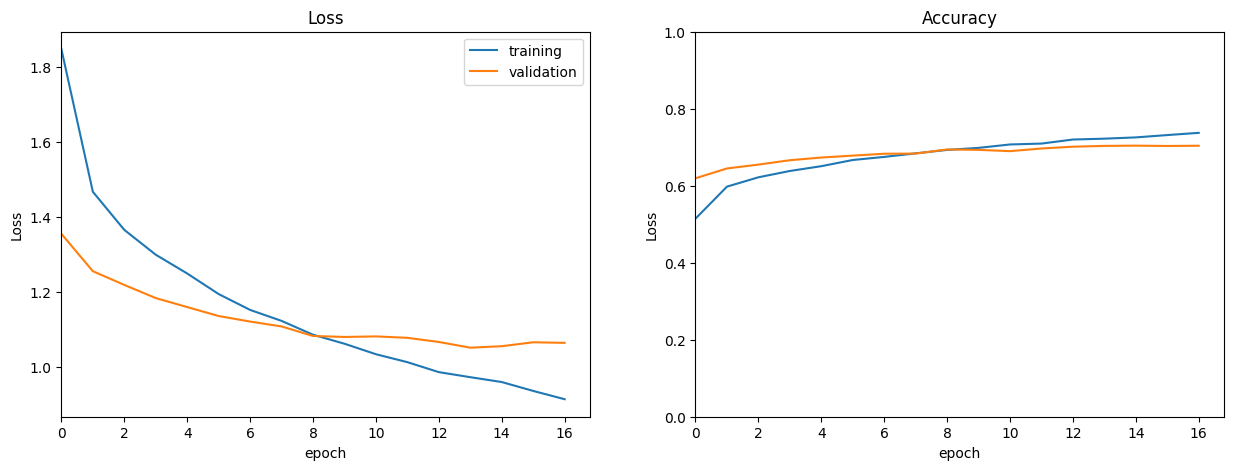

In [43]:
plot_history(history_pretrained)

With only 10 training rounds, the pretrained model's accuracy is twice that of the previous model.

In [44]:
pretrained.save_weights('/kaggle/working/models/pretrained_top_300.weights.h5')

### Fine tuning

We now unfreeze the bottom layer and fine tune the model using a reduced learning rate.

In [50]:
EfficientNetV2B0.trainable = True
optimizer = keras.optimizers.Adam(learning_rate=1E-5) #learning rate reduce by a factor of 10
pretrained.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pretrained.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 10, 10, 1280)      5919312   Y          
 nal)                                                                       
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0         Y          
                                                                            
 dense (Dense)               (None, 512)               655872

In [51]:
history_pretrained_fine = pretrained.fit(ds_train, validation_data=ds_valid, epochs=30, callbacks=[early_stopping])

Epoch 1/30
1339/1339 [==============================] - 330s 209ms/step - loss: 0.8802 - accuracy: 0.7488 - val_loss: 0.9890 - val_accuracy: 0.7198
Epoch 2/30
1339/1339 [==============================] - 278s 207ms/step - loss: 0.8220 - accuracy: 0.7649 - val_loss: 0.9646 - val_accuracy: 0.7289
Epoch 3/30
1339/1339 [==============================] - 276s 206ms/step - loss: 0.7863 - accuracy: 0.7763 - val_loss: 0.9522 - val_accuracy: 0.7306
Epoch 4/30
1339/1339 [==============================] - 277s 207ms/step - loss: 0.7589 - accuracy: 0.7817 - val_loss: 0.9491 - val_accuracy: 0.7335
Epoch 5/30
1339/1339 [==============================] - 276s 206ms/step - loss: 0.7276 - accuracy: 0.7946 - val_loss: 0.9446 - val_accuracy: 0.7337
Epoch 6/30
1339/1339 [==============================] - 278s 207ms/step - loss: 0.7055 - accuracy: 0.8015 - val_loss: 0.9370 - val_accuracy: 0.7367
Epoch 7/30
1339/1339 [==============================] - 278s 208ms/step - loss: 0.6791 - accuracy: 0.8072 - val_

In [53]:
pretrained.save_weights('/kaggle/working/models/pretrained_fine_300.weights.h5')

In [48]:
#pretrained.load_weights('/kaggle/working/models/pretrained_fine.weights.h5')

In [55]:
predictions = pretrained.predict(ds_valid)
prediction_class = np.argmax(predictions, axis=1)
list_valid = list(ds_valid.unbatch())

149/149 [==============================] - 11s 61ms/step


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,20))
                      
for i in range(3):
    n = np.random.randint(0, len(predictions))
    image, label = list_valid[n]
    axs[i].imshow(image.numpy().astype("uint8"))
    if prediction_class[n] == label:
        axs[i].set_title(ds_train.class_names[prediction_class[n]], size=15, color='green')
    else:
        axs[i].set_title(ds_train.class_names[prediction_class[n]] + f' ({ds_train.class_names[label]})', size=15, color='red')